<a href="https://colab.research.google.com/github/abhishekwynum/AI-Research-2022/blob/main/NOUGAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q pymupdf python-Levenshtein nltk
!pip install -q git+https://github.com/huggingface/transformers.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 54.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 58.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
from transformers import AutoProcessor, VisionEncoderDecoderModel
import torch

# Load the Nougat model and processor from the hub
model_name = "facebook/nougat-base" # swith to "facebook/nougat-small" for faster inference but low accuracy
processor = AutoProcessor.from_pretrained(model_name)
model = VisionEncoderDecoderModel.from_pretrained(model_name)

preprocessor_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.49k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.14M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/96.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.77k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.40G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/165 [00:00<?, ?B/s]

In [3]:
%%capture
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

In [4]:
from typing import Optional, List
import io
import fitz
from pathlib import Path

def rasterize_paper(
    pdf: Path,
    outpath: Optional[Path] = None,
    dpi: int = 96,
    return_pil=False,
    pages=None,
) -> Optional[List[io.BytesIO]]:
    """
    Rasterize a PDF file to PNG images.

    Args:
        pdf (Path): The path to the PDF file.
        outpath (Optional[Path], optional): The output directory. If None, the PIL images will be returned instead. Defaults to None.
        dpi (int, optional): The output DPI. Defaults to 96.
        return_pil (bool, optional): Whether to return the PIL images instead of writing them to disk. Defaults to False.
        pages (Optional[List[int]], optional): The pages to rasterize. If None, all pages will be rasterized. Defaults to None.

    Returns:
        Optional[List[io.BytesIO]]: The PIL images if `return_pil` is True, otherwise None.
    """

    pillow_images = []
    if outpath is None:
        return_pil = True
    try:
        if isinstance(pdf, (str, Path)):
            pdf = fitz.open(pdf)
        if pages is None:
            pages = range(len(pdf))
        for i in pages:
            page_bytes: bytes = pdf[i].get_pixmap(dpi=dpi).pil_tobytes(format="PNG")
            if return_pil:
                pillow_images.append(io.BytesIO(page_bytes))
            else:
                with (outpath / ("%02d.png" % (i + 1))).open("wb") as f:
                    f.write(page_bytes)
    except Exception:
        pass
    if return_pil:
        return pillow_images

In [7]:
from transformers import StoppingCriteria, StoppingCriteriaList
from collections import defaultdict

class RunningVarTorch:
    def __init__(self, L=15, norm=False):
        self.values = None
        self.L = L
        self.norm = norm

    def push(self, x: torch.Tensor):
        assert x.dim() == 1
        if self.values is None:
            self.values = x[:, None]
        elif self.values.shape[1] < self.L:
            self.values = torch.cat((self.values, x[:, None]), 1)
        else:
            self.values = torch.cat((self.values[:, 1:], x[:, None]), 1)

    def variance(self):
        if self.values is None:
            return
        if self.norm:
            return torch.var(self.values, 1) / self.values.shape[1]
        else:
            return torch.var(self.values, 1)


class StoppingCriteriaScores(StoppingCriteria):
    def __init__(self, threshold: float = 0.015, window_size: int = 200):
        super().__init__()
        self.threshold = threshold
        self.vars = RunningVarTorch(norm=True)
        self.varvars = RunningVarTorch(L=window_size)
        self.stop_inds = defaultdict(int)
        self.stopped = defaultdict(bool)
        self.size = 0
        self.window_size = window_size

    @torch.no_grad()
    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor):
        last_scores = scores[-1]
        self.vars.push(last_scores.max(1)[0].float().cpu())
        self.varvars.push(self.vars.variance())
        self.size += 1
        if self.size < self.window_size:
            return False

        varvar = self.varvars.variance()
        for b in range(len(last_scores)):
            if varvar[b] < self.threshold:
                if self.stop_inds[b] > 0 and not self.stopped[b]:
                    self.stopped[b] = self.stop_inds[b] >= self.size
                else:
                    self.stop_inds[b] = int(
                        min(max(self.size, 1) * 1.15 + 150 + self.window_size, 4095)
                    )
            else:
                self.stop_inds[b] = 0
                self.stopped[b] = False
        return all(self.stopped.values()) and len(self.stopped) > 0


In [10]:
filepath

'/root/.cache/huggingface/hub/datasets--inuwamobarak--random-files/snapshots/8ad45fc56c4ea0705d13ef1c774cbf62f751555a/2310.08535.pdf'

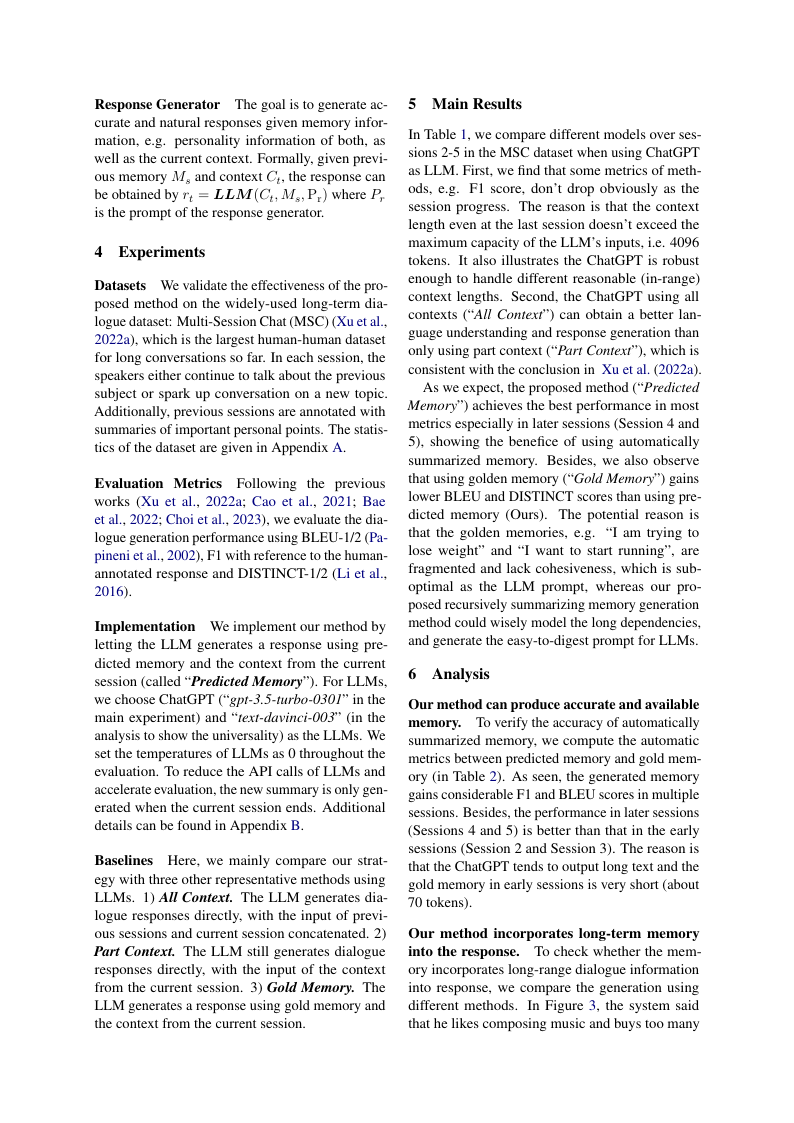

In [13]:
from huggingface_hub import hf_hub_download
from typing import Optional, List
import io
import fitz
from pathlib import Path
from PIL import Image

# filepath = hf_hub_download(repo_id="inuwamobarak/random-files", filename="2310.08535.pdf", repo_type="dataset")
filepath = "/content/drive/MyDrive/Wynum Projects/paper.pdf"

images = rasterize_paper(pdf=filepath, return_pil=True)
image = Image.open(images[2])
image


In [14]:
pixel_values = processor(images=image, return_tensors="pt").pixel_values

outputs = model.generate(
    pixel_values.to(device),
    min_length=1,
    max_length=3584,
    bad_words_ids=[[processor.tokenizer.unk_token_id]],
    return_dict_in_generate=True,
    output_scores=True,
    stopping_criteria=StoppingCriteriaList([StoppingCriteriaScores()]),
)

In [15]:
generated = processor.batch_decode(outputs[0], skip_special_tokens=True)[0]

generated = processor.post_process_generation(generated, fix_markdown=False)

print(generated)

Response GeneratorThe goal is to generate accurate and natural responses given memory information, e.g. personality information of both, as well as the current context. Formally, given previous memory \(M_{s}\) and context \(C_{t}\), the response can be obtained by \(r_{t}=\bm{L}\bm{L}\bm{M}(C_{t},M_{s},\mathrm{P_{r}})\) where \(P_{r}\) is the prompt of the response generator.

## 4 Experiments

DatasetsWe validate the effectiveness of the proposed method on the widely-used long-term dialogue dataset: Multi-Session Chat (MSC) Xu et al. (2022), which is the largest human-human dataset for long conversations so far. In each session, the speakers either continue to talk about the previous subject or spark up conversation on a new topic. Additionally, previous sessions are annotated with summaries of important personal points. The statistics of the dataset are given in Appendix A.

Evaluation MetricsFollowing the previous works Xu et al. (2022); Cao et al. (2021); Bae et al. (2022); Choi e